# Import libraries yang dibutuhkan

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

# Data Understanding

#### a. Gunakan Data Dictionary sebagai Panduan Utama

#### b. Lakukan Pemeriksaan Kualitas Data Awal

In [2]:
# Memuat dataset dengan batasan 100 baris pertama
df = pd.read_csv('loan_data_2007_2014.csv', nrows=3000)

# Menghapus kolom yang tidak memiliki nilai non-null
df = df.dropna(axis=1, how='all')

# Menangani nilai yang hilang untuk kolom numerik
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='median')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

# Menangani nilai yang hilang untuk kolom kategorikal
cat_cols = df.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='constant', fill_value='Unknown')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Encoding variabel kategorikal
le = LabelEncoder()
one_hot_encoded_cols = []
for feature in cat_cols:
    if df[feature].nunique() < 10:  # Gunakan LabelEncoder untuk fitur dengan sedikit kategori unik
        df[feature] = le.fit_transform(df[feature])
    else:  # Gunakan OneHotEncoder untuk fitur dengan banyak kategori unik
        one_hot_encoded_cols.append(feature)

# Menggunakan OneHotEncoder pada fitur yang memiliki banyak kategori unik
df = pd.get_dummies(df, columns=one_hot_encoded_cols, drop_first=True)

# Memeriksa apakah ada nilai yang hilang setelah persiapan data
print(df.isnull().sum())

# Memeriksa apakah ada nilai inf dalam data
print(np.isinf(df).sum())

# Menghapus kolom atau baris yang mengandung nilai inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

Unnamed: 0                   0
id                           0
member_id                    0
loan_amnt                    0
funded_amnt                  0
                            ..
last_credit_pull_d_Oct-15    0
last_credit_pull_d_Sep-12    0
last_credit_pull_d_Sep-13    0
last_credit_pull_d_Sep-14    0
last_credit_pull_d_Sep-15    0
Length: 9888, dtype: int64
Unnamed: 0                   0
id                           0
member_id                    0
loan_amnt                    0
funded_amnt                  0
                            ..
last_credit_pull_d_Oct-15    0
last_credit_pull_d_Sep-12    0
last_credit_pull_d_Sep-13    0
last_credit_pull_d_Sep-14    0
last_credit_pull_d_Sep-15    0
Length: 9888, dtype: int64


# Exploratory Data Analysis (EDA)

#### a. Gunakan EDA secara Kreatif

   Unnamed: 0         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0         0.0  1077501.0  1296599.0     5000.0       5000.0           4975.0   
1         1.0  1077430.0  1314167.0     2500.0       2500.0           2500.0   
2         2.0  1077175.0  1313524.0     2400.0       2400.0           2400.0   
3         3.0  1076863.0  1277178.0    10000.0      10000.0          10000.0   
4         4.0  1075358.0  1311748.0     3000.0       3000.0           3000.0   

   term  int_rate  installment  grade  ...  last_credit_pull_d_Nov-14  \
0     0     10.65       162.87      1  ...                      False   
1     1     15.27        59.83      2  ...                      False   
2     0     15.96        84.33      2  ...                      False   
3     0     13.49       339.31      2  ...                      False   
4     1     12.69        67.79      1  ...                      False   

   last_credit_pull_d_Nov-15  last_credit_pull_d_Oct-12  \
0                    

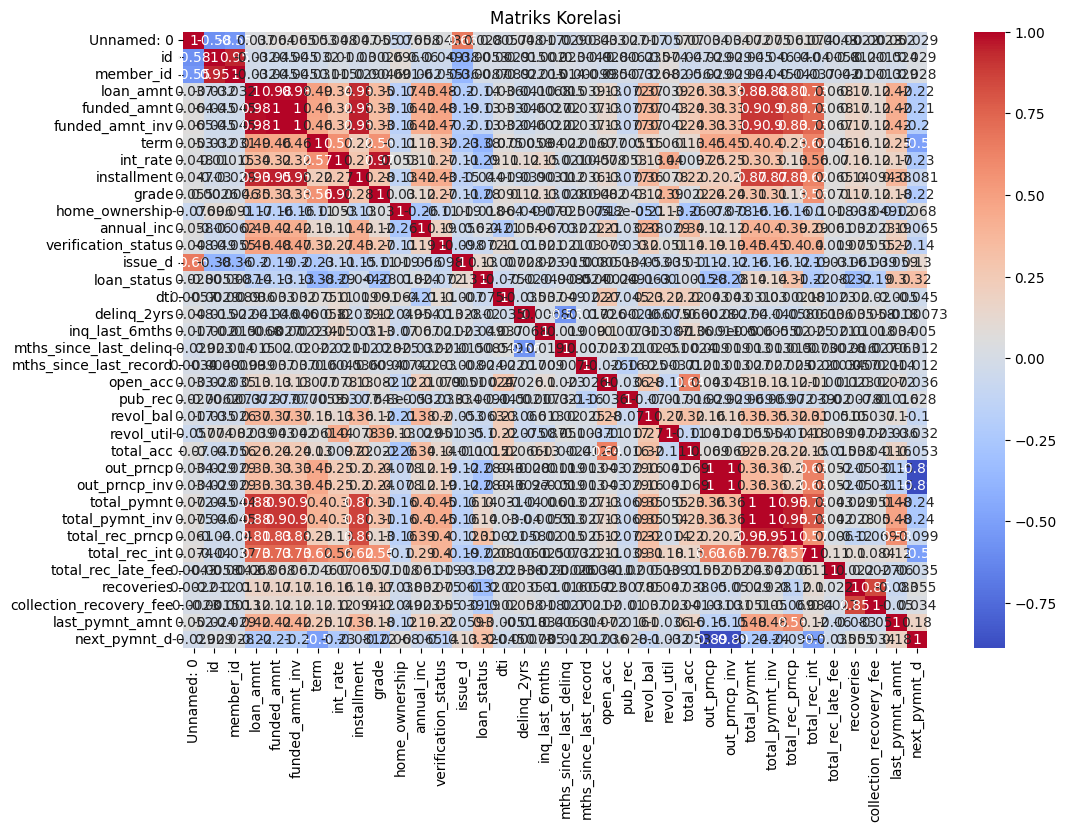

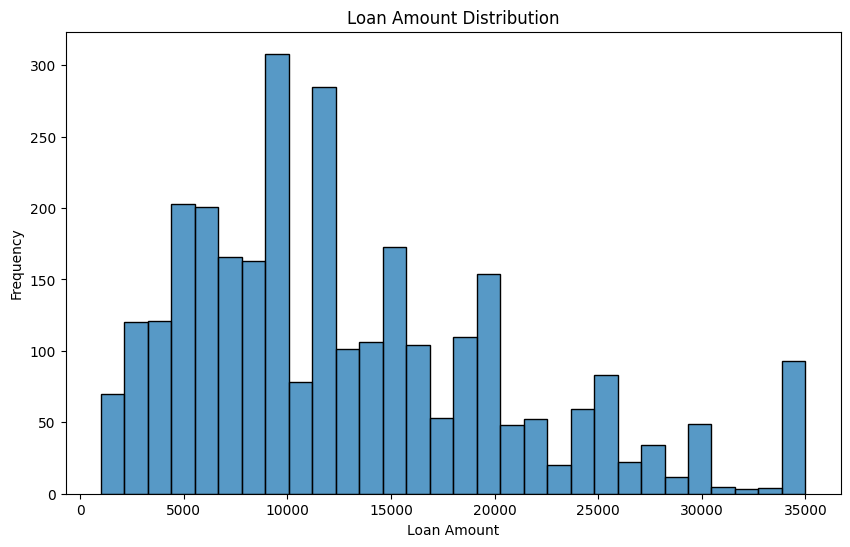

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengubah `term` menjadi numerik jika kolom `term` ada di dalam dataset
if 'term' in df.columns:
    df['term'] = df['term'].apply(lambda x: int(x.replace(' months', '')) if isinstance(x, str) else x)

# Menampilkan beberapa baris pertama dataset
print(df.head())

# Memastikan hanya kolom numerik yang digunakan dalam analisis korelasi
num_df = df.select_dtypes(include=[np.number])

# Menghapus kolom yang hanya mengandung satu nilai unik (tidak ada variasi)
num_df = num_df.loc[:, num_df.nunique() > 1]

# Korelasi antara fitur-fitur numerik
plt.figure(figsize=(12, 8))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()

# Visualize loan amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_amnt'], bins=30)
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

# Data Preparation

#### a. Menangani Nilai yang Hilang

In [4]:
# Scaling fitur numerik
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Memastikan tidak ada nilai yang tidak valid setelah scaling
print(np.any(np.isnan(df[num_cols])))
print(np.any(np.isinf(df[num_cols])))

# Membagi data menjadi train set dan test set
if 'loan_status' in df.columns:
    X = df.drop('loan_status', axis=1)
    y = df['loan_status']
else:
    raise ValueError("Kolom 'loan_status' tidak ditemukan dalam dataset.")
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

False
False
Train set shape: (2400, 9887), Test set shape: (600, 9887)


# Data Modelling

#### a. Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Definisikan model dan parameter grid untuk tuning
log_reg = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
log_reg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# Fit model
log_reg_cv.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", log_reg_cv.best_params_)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


#### b. SVM Model

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Create SVM Classifier and GridSearchCV object
svm_cv = GridSearchCV(SVC(), param_grid_svm, cv=5)

# Fit the model
svm_cv.fit(X_train, y_train)

# Predict on the test set
y_pred_svm_cv = svm_cv.predict(X_test)

# Evaluation

#### a. Evaluasi Model Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predictions and confusion matrix
y_pred_log_reg = log_reg.predict(X_test)
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Calculate the evaluation metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='macro')  # Use 'macro' for multi-class
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='macro')        # Use 'macro' for multi-class
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='macro')                # Use 'macro' for multi-class

# Calculate the number of True Positives, False Positives, True Negatives, and False Negatives
TN_log_reg = cm_log_reg[0, 0]
FP_log_reg = cm_log_reg[0, 1]
FN_log_reg = cm_log_reg[1, 0]
TP_log_reg = cm_log_reg[1, 1]

# Proportion of good and risky loans in the portfolio
portofolio_good_log_reg = TP_log_reg / (TP_log_reg + FP_log_reg) * 100
portofolio_risky_log_reg = FP_log_reg / (TP_log_reg + FP_log_reg) * 100

# Investment in good loans
investment_good_log_reg = TP_log_reg / (TP_log_reg + FN_log_reg) * 100

# Ratio of risky loans avoided
avoided_risky_log_reg = FN_log_reg / (FN_log_reg + TN_log_reg) * 100
avoided_good_log_reg = TN_log_reg / (FN_log_reg + TN_log_reg) * 100

# Summary for Logistic Regression
print(f"Logistic Regression: If we choose Logistic Regression as the algorithm, our portfolio will consist of {portofolio_good_log_reg:.2f}% good loans : {portofolio_risky_log_reg:.2f}% risky loans, and we will invest in {investment_good_log_reg:.2f}% of the available good loans. It can also avoid {avoided_risky_log_reg:.2f} risky loans for every 100 loans avoided (avoiding {avoided_risky_log_reg:.0f} risky : {avoided_good_log_reg:.0f} good).")

#### b. Evaluasi Model SVM

In [ ]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM model
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predictions on the test set
y_pred_svm = svm.predict(X_test)

# Calculate the confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Calculate the evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='macro')  # Use 'macro' for multi-class
recall_svm = recall_score(y_test, y_pred_svm, average='macro')        # Use 'macro' for multi-class
f1_svm = f1_score(y_test, y_pred_svm, average='macro')                # Use 'macro' for multi-class

# Calculate the number of True Positives, False Positives, True Negatives, and False Negatives
TN_svm = cm_svm[0, 0]
FP_svm = cm_svm[0, 1]
FN_svm = cm_svm[1, 0]
TP_svm = cm_svm[1, 1]

# Calculate the proportions and investment for SVM
portofolio_good_svm = TP_svm / (TP_svm + FP_svm) * 100
portofolio_risky_svm = FP_svm / (TP_svm + FP_svm) * 100
investment_good_svm = TP_svm / (TP_svm + FN_svm) * 100

# Avoid division by zero
if FN_svm + TN_svm == 0:
    avoided_risky_svm = 0
    avoided_good_svm = 0
else:
    # Ratio of risky loans avoided
    avoided_risky_svm = FN_svm / (FN_svm + TN_svm) * 100
    avoided_good_svm = TN_svm / (FN_svm + TN_svm) * 100

# Summary for SVM
print(f"SVM: If we choose SVM as the algorithm, our portfolio will consist of {portofolio_good_svm:.2f}% good loans : {portofolio_risky_svm:.2f}% risky loans, and we will invest in {investment_good_svm:.2f}% of the available good loans. It can also avoid {avoided_risky_svm:.2f} risky loans for every 100 loans avoided (avoiding {avoided_risky_svm:.0f} risky : {avoided_good_svm:.0f} good).")